# Question 1

RA and Dec published are usually for the epoch J2000. Do RA and Dec change today?

We transform the published Cygnus A coordinates (given in FK5, equinox J2000) to the FK5 frame with the equinox set to the current date/time. This transformation shows the change due to precession (and related effects). We will print both coordinate representations and the difference in arcseconds.

In [2]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, FK5
import astropy.units as u

# Published Cygnus A (J2000)
ra_str = "19h59m28.35665s"
dec_str = "+40d44m02.096s"

t_now = Time.now()  # current time (UTC)
cyga_j2000 = SkyCoord(ra=ra_str, dec=dec_str, frame=FK5, equinox=Time('J2000'))
cyga_now_fk5 = cyga_j2000.transform_to(FK5(equinox=t_now))

print("Published (J2000):")
print("  RA  =", cyga_j2000.ra.to_string(unit=u.hour, sep=':', precision=6))
print("  Dec =", cyga_j2000.dec.to_string(unit=u.degree, sep=':', precision=3))

print("\nTransformed to FK5 equinox =", t_now.iso)
print("  RA  =", cyga_now_fk5.ra.to_string(unit=u.hour, sep=':', precision=6))
print("  Dec =", cyga_now_fk5.dec.to_string(unit=u.degree, sep=':', precision=3))

# Differences in arcseconds
delta_ra_arcsec = (cyga_now_fk5.ra.degree - cyga_j2000.ra.degree) * 3600.0
delta_dec_arcsec = (cyga_now_fk5.dec.degree - cyga_j2000.dec.degree) * 3600.0
print(f"\nCoordinate shift since J2000: ΔRA = {delta_ra_arcsec:.6f} arcsec, ΔDec = {delta_dec_arcsec:.6f} arcsec")

Published (J2000):
  RA  = 19:59:28.356650
  Dec = 40:44:02.096

Transformed to FK5 equinox = 2026-01-18 10:10:12.937
  RA  = 20:00:22.461387
  Dec = 40:48:22.959

Coordinate shift since J2000: ΔRA = 811.571058 arcsec, ΔDec = 260.863092 arcsec


# Question 2

What are the azimuth and elevation of this source when observing from IIT Kanpur?

We compute the Alt/Az of Cygnus A for the observer at IIT Kanpur (lat=26.5123 N, lon=80.2329 E, height=142 m) at the current time (`Time.now()`). The results print UTC observation time and the approximate IST equivalent.

In [8]:

from astropy.coordinates import EarthLocation, AltAz, FK5, SkyCoord
from astropy.time import Time
import astropy.units as u
from datetime import timezone, timedelta

from astropy.utils.iers import conf
conf.auto_max_age = None

# IIT Kanpur location
iitk = EarthLocation(lat=26.5123*u.deg, lon=80.2329*u.deg, height=142*u.m)

# Time
t_now = Time.now()
t_now_ist = t_now.to_datetime(timezone.utc) + timedelta(hours=5, minutes=30)

# Cygnus A (J2000)
cyga_j2000 = SkyCoord(
    ra="19h59m28.35665s",
    dec="+40d44m02.096s",
    frame=FK5,
    equinox=Time('J2000')
)

# Transform to AltAz
altaz_frame = AltAz(obstime=t_now, location=iitk)
cyga_altaz_now = cyga_j2000.transform_to(altaz_frame)

print("Observation time (UTC):", t_now.iso)
print("Approx IST:", t_now_ist.isoformat(sep=' '))
print("\nCygnus A at IIT Kanpur:")
print(f"  Azimuth (deg)     = {cyga_altaz_now.az.degree:.6f}")
print(f"  Elevation (deg)   = {cyga_altaz_now.alt.degree:.6f}")

Observation time (UTC): 2026-01-18 10:15:12.687
Approx IST: 2026-01-18 15:45:12.687000+00:00

Cygnus A at IIT Kanpur:
  Azimuth (deg)     = 302.283218
  Elevation (deg)   = 45.290126


# Question 3

Show in a polar plot how the azimuth and elevation change when observing at IIT Kanpur.

We compute the source's azimuth and elevation over a 24-hour interval centered on the current time. For the polar plot:
- angle = azimuth (0° = North, increasing clockwise)
- radius = zenith distance = 90° - elevation (so center = zenith, outer = horizon)
This is a common way to visualize sky tracks as polar plots.

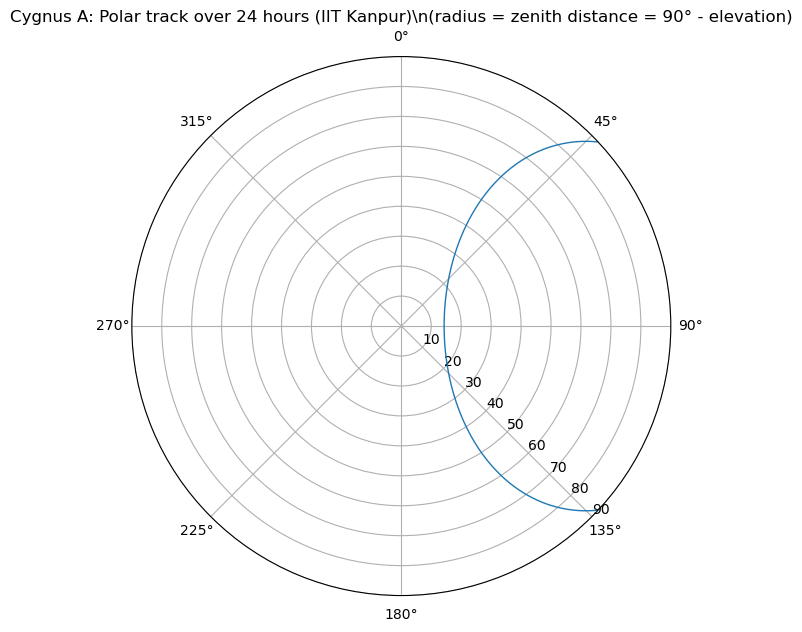

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import AltAz, SkyCoord, FK5, EarthLocation
import astropy.units as u

from astropy.utils import iers
iers.conf.auto_download = False

iitk = EarthLocation(lat=26.5123*u.deg, lon=80.2329*u.deg, height=142*u.m)
t_now = Time.now()
cyga_j2000 = SkyCoord(ra="19h59m28.35665s", dec="+40d44m02.096s", frame=FK5, equinox=Time('J2000'))

# sample 24 hours (1000 points)
times_24h = Time(np.linspace(t_now.jd - 0.5, t_now.jd + 0.5, 1000), format='jd')
altaz_24h = cyga_j2000.transform_to(AltAz(obstime=times_24h, location=iitk))

az_24 = altaz_24h.az.degree
el_24 = altaz_24h.alt.degree

# Convert to polar for plotting
theta = np.deg2rad(90.0 - az_24)  # matplotlib: 0 at east; shift so 0 = North and CW positive
r = 90.0 - el_24  # zenith distance

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, polar=True)
ax.plot(theta, r, linewidth=1)
ax.set_theta_zero_location('N')  # 0 at north
ax.set_theta_direction(-1)       # clockwise
ax.set_rlim(0,90)
ax.set_rlabel_position(135)
ax.set_title('Cygnus A: Polar track over 24 hours (IIT Kanpur)\\n(radius = zenith distance = 90° - elevation)')
plt.show()

# Question 4

Plot how the Sun's RA and Dec change over a year. Compare this with Cygnus A.

We compute the Sun's RA/Dec for each day of the current year, transform the Sun coordinates to FK5 (equinox J2000) so the comparison is made in the same reference frame. We plot Sun RA and Dec vs day and overplot Cygnus A's RA/Dec to show the (vast) difference in scale: the Sun moves across many degrees in RA and Dec, while Cygnus A is essentially fixed except for very small precession-induced shifts.

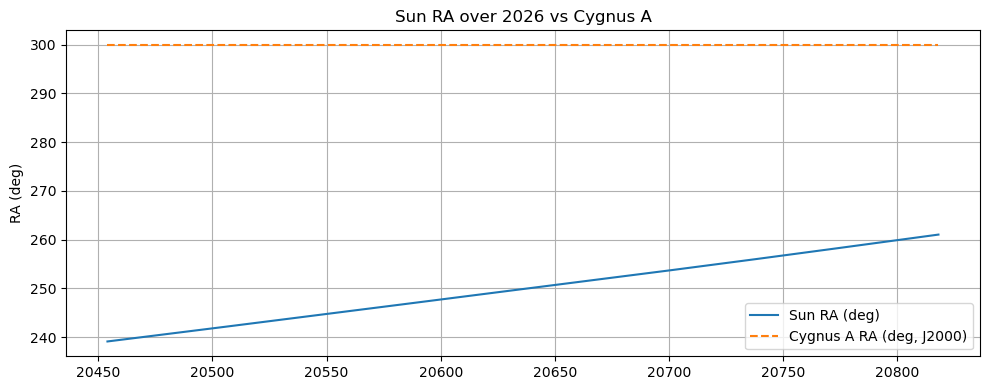

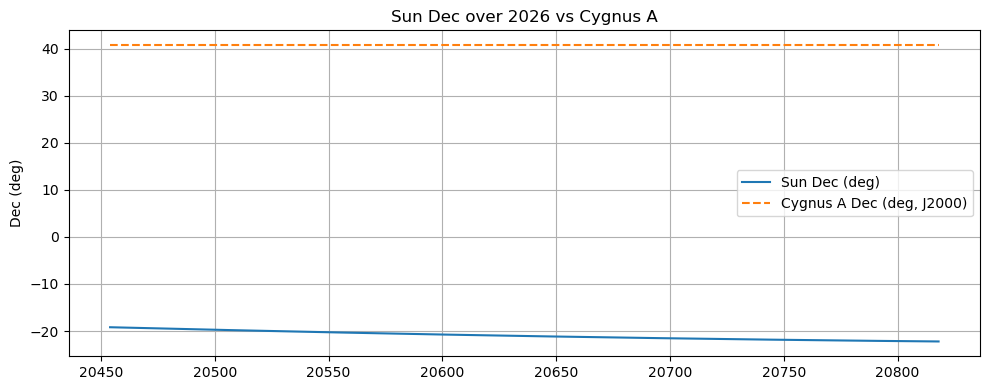

In [9]:

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import get_sun, FK5, SkyCoord
from astropy.time import Time
import astropy.units as u

year = Time.now().datetime.year
times_year = Time(np.linspace(Time(f"{year}-01-01").jd, Time(f"{year}-12-31").jd, 365), format='jd')

sun_fk5_j2000 = get_sun(times_year).transform_to(FK5(equinox=Time('J2000')))

# Cygnus A base coordinate (J2000)
cyga_j2000 = SkyCoord(ra="19h59m28.35665s", dec="+40d44m02.096s", frame=FK5, equinox=Time('J2000'))
cyga_ra_deg = cyga_j2000.ra.degree
cyga_dec_deg = cyga_j2000.dec.degree

# Plot RA (in degrees)
plt.figure(figsize=(10,4))
plt.plot(times_year.plot_date, sun_fk5_j2000.ra.wrap_at(360*u.deg).degree, label='Sun RA (deg)')
plt.plot(times_year.plot_date, np.full(len(times_year), cyga_ra_deg), '--', label='Cygnus A RA (deg, J2000)')
plt.ylabel('RA (deg)')
plt.title(f'Sun RA over {year} vs Cygnus A')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Plot Dec
plt.figure(figsize=(10,4))
plt.plot(times_year.plot_date, sun_fk5_j2000.dec.degree, label='Sun Dec (deg)')
plt.plot(times_year.plot_date, np.full(len(times_year), cyga_dec_deg), '--', label='Cygnus A Dec (deg, J2000)')
plt.ylabel('Dec (deg)')
plt.title(f'Sun Dec over {year} vs Cygnus A')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()